In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
# 앞쪽 3개의 숫자를 바탕으로 그 다음에 오는 숫자를 예측하는 경우

tf.keras.layer.SimpleRNN(units=10, activation='tanh', ipunt_shape=(3, 1)) # 기본적으로는 3개의 파라미터 사용
# units = 10 : 일반 신경망의 은닉층 노드수와 같은 개념
#                   즉, units = 10 의미는 SimpleRNN레이어 내의 노드 개수는 10개이며 노드 1개당 활성화 함수 1개를 가지고 있음
# activation = 'tanh' : 'relu'같은 다른 활성화 함수를 사용할 수도 있음
# input_shape = (3, 1) : 3 : 3개의 time-step데이터를 이용해서 정답을 만든다는 의미이며 window_size = 3 과 같음
#                                   1 : RNN레이어로 한번에 1개의 데이터가 들어간다는 의미

In [3]:
x = np.arange(0, 100, 0.1)
y = 0.5*np.sin(2*x) - np.cos(x/2.0) # -> 1000개의 시계열 데이터

seq_data = y.reshape(-1, 1) 
# RNN 입력에 필수적인 (batch_size, time_steps, input_dim) 3차원 텐서 형태의 입력 데이터로 쉽게 만들기 위해서
# reshape(-1, 1)를 사용하여 (1000, 1) 행렬로 바꾸어줌

In [4]:
seq_data[:10]

array([[-1.        ],
       [-0.89941559],
       [-0.80029499],
       [-0.70644984],
       [-0.62138853],
       [-0.54817693],
       [-0.48931695],
       [-0.44664785],
       [-0.42127419],
       [-0.41352329]])

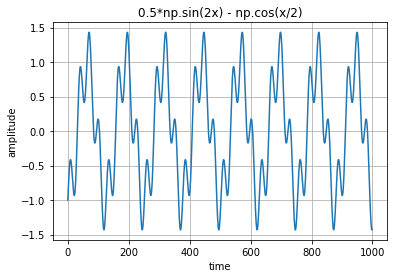

In [5]:
plt.grid()
plt.title('0.5*np.sin(2x) - np.cos(x/2)')
plt.xlabel('time')
plt.ylabel('amplitude')
plt.plot(seq_data)

plt.show()

[2] 입력데이터 X, 정답데이터 Y 생성

In [6]:
def seq2dataset(seq, window, horizon):
    
    X = [] # 입력 데이터를 저장하는 list
    Y = [] # 정답 데이터를 저장하는 list
    
    for i in range(len(seq)-(window+horizon) + 1):
        x = seq[i:(i+window)]
        # 여기서 x는 20개의 데이터를 뽑아냄
        # seq[i:(i+window)] 슬라이싱 이용하여 [[..], [..], [..]] 형상으로 X데이터를 생성함
        y = (seq[i+window+horizon-1]) 
        # 여기서 y는 20개의 데이터 다음인 21번째의 데이터를 정답데이터로 삽입
        
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)
    #  x.shape = [[...], [...], [...], ...] 은 2차원 행렬인데, np.array(X)를 통해서 
    # (batch_size, time_steps, input_dims) 형상을 가지는 3차원 텐서로 변환되어 리턴

In [7]:
w = 20 # window_size
h = 1    # horizon factor

X, Y = seq2dataset(seq_data, w, h) 
#  시계열 데이터 seq_data로 부터, window_size w, horizon factor h에 맞게 RNN 입력 데이터 X, 정답 데이터 Y 생섬함.
# 이때 리턴되는 입력데이터 X.shape = (batch_size, time_steps, input_dims)

print(X.shape, Y.shape)

(980, 20, 1) (980, 1)


In [8]:
lst = [[i for i in range(0, 20)], [i for i in range(20, 40)]]
print(lst)
lst = np.array(lst)
print(lst)
print(lst.shape)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]]
(2, 20)


In [9]:
import keras

[3] 트레이닝 데이터 / 테스트 데이터 분리

In [10]:
split_ratio = 0.8

split = int(split_ratio*len(X))

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
# train data : 784개 / test data : 196개

(784, 20, 1) (784, 1) (196, 20, 1) (196, 1)


[4] Simple RNN 모델 구축

In [13]:
model = keras.models.Sequential()

model.add(SimpleRNN(units=128,
                                       activation='tanh',
                                       input_shape=x_train[0].shape)) 
# SimpleRNN계층에 tanh를 활성화 함수로 가지는 노드 수 128개
# input_shape = (20, 1)

model.add(Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16640     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


[5] SimpleRNN 모델 컴파일 및 학습

In [14]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

hist = model.fit(x_train, y_train, epochs=100, validation_data = (x_test, y_test))

Epoch 1/100
25/25 [==============================] - 6s 63ms/step - loss: 0.0712 - mae: 0.1795 - val_loss: 0.0081 - val_mae: 0.0717
Epoch 2/100
25/25 [==============================] - 1s 24ms/step - loss: 0.0031 - mae: 0.0436 - val_loss: 0.0013 - val_mae: 0.0295
Epoch 3/100
25/25 [==============================] - 1s 24ms/step - loss: 0.0011 - mae: 0.0260 - val_loss: 8.7035e-04 - val_mae: 0.0227
Epoch 4/100
25/25 [==============================] - 1s 24ms/step - loss: 7.0265e-04 - mae: 0.0205 - val_loss: 5.5519e-04 - val_mae: 0.0186
Epoch 5/100
25/25 [==============================] - 1s 25ms/step - loss: 4.2824e-04 - mae: 0.0159 - val_loss: 3.9215e-04 - val_mae: 0.0152
Epoch 6/100
25/25 [==============================] - 1s 24ms/step - loss: 5.4693e-04 - mae: 0.0186 - val_loss: 4.7068e-04 - val_mae: 0.0183
Epoch 7/100
25/25 [==============================] - 1s 24ms/step - loss: 3.3555e-04 - mae: 0.0144 - val_loss: 3.5660e-04 - val_mae: 0.0155
Epoch 8/100
25/25 [=====================

25/25 [==============================] - 1s 24ms/step - loss: 3.4509e-05 - mae: 0.0046 - val_loss: 6.9591e-05 - val_mae: 0.0071
Epoch 60/100
25/25 [==============================] - 1s 24ms/step - loss: 1.8723e-05 - mae: 0.0033 - val_loss: 1.2822e-05 - val_mae: 0.0027
Epoch 61/100
25/25 [==============================] - 1s 24ms/step - loss: 1.1733e-05 - mae: 0.0027 - val_loss: 7.9919e-06 - val_mae: 0.0023
Epoch 62/100
25/25 [==============================] - 1s 25ms/step - loss: 3.9463e-05 - mae: 0.0046 - val_loss: 1.1290e-04 - val_mae: 0.0091
Epoch 63/100
25/25 [==============================] - 1s 23ms/step - loss: 8.8270e-05 - mae: 0.0076 - val_loss: 5.8777e-05 - val_mae: 0.0065
Epoch 64/100
25/25 [==============================] - 1s 25ms/step - loss: 3.4596e-05 - mae: 0.0047 - val_loss: 3.0336e-05 - val_mae: 0.0044
Epoch 65/100
25/25 [==============================] - 1s 26ms/step - loss: 5.4130e-05 - mae: 0.0058 - val_loss: 1.6981e-05 - val_mae: 0.0034
Epoch 66/100
25/25 [======

[6] 정확도 및 손실

In [15]:
pred = model.predict(x_test)
print(pred.shape)

7/7 [==============================] - 1s 10ms/step
(196, 1)


In [16]:
rand_idx = np.random.randint(0, len(y_test), size=5)

print('rand_idx = ', rand_idx, '\n')
print('pred = ', pred.flatten()[rand_idx])
print('labe l = ', y_test.flatten()[rand_idx])

rand_idx = np.random.randint(0, len(y_test), size=5)

print('\n\nrand_idx = ', rand_idx, '\n')
print('pred = ', pred.flatten()[rand_idx])
print('labe l = ', y_test.flatten()[rand_idx])

rand_idx =  [ 23 127   1  27 184] 

pred =  [ 1.3249376   0.467132    0.48076823  0.91638356 -0.4906859 ]
labe l =  [ 1.31968788  0.46546723  0.47934463  0.90868638 -0.49082954]


rand_idx =  [ 75  81 164 179 145] 

pred =  [-1.065936   -0.52562207 -0.16857728  0.04825045  1.4312245 ]
labe l =  [-1.06389327 -0.52558618 -0.171624    0.04465513  1.42966394]


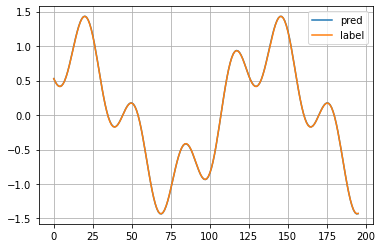

In [19]:
plt.plot(pred, label = 'pred')
plt.plot(y_test, label='label')
plt.grid()
plt.legend(loc='best')

plt.show()